Purpose:
---------
This script performs anomaly detection on TESS light curve flux data for star TIC 129646813
using the DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm.
The aim is to detect potential stellar flare events by identifying flux observations that
deviate significantly from typical behavior.

Workflow:
--------
1. Loading and preprocessing the flux data
2. Standardizing the flux values
3. Using grid search to find the best combination of eps and min_samples
4. Applying DBSCAN with specific parameter settings
5. Identifying and clustering nearby outlier points based on time proximity
6. Plotting and visualizing detected anomalies


In [ ]:
# Workspace setup
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [ ]:
# Import data
from google.colab import files
uploaded = files.upload()

Saving 129646813_flux_only.csv to 129646813_flux_only.csv


In [ ]:
# Load data and standardize
df = pd.read_csv("129646813_flux_only.csv")
df = df.dropna(subset=['pdcsap_flux'])
X = df[['pdcsap_flux']].values
X_scaled = StandardScaler().fit_transform(X)  # Standardize for better performance

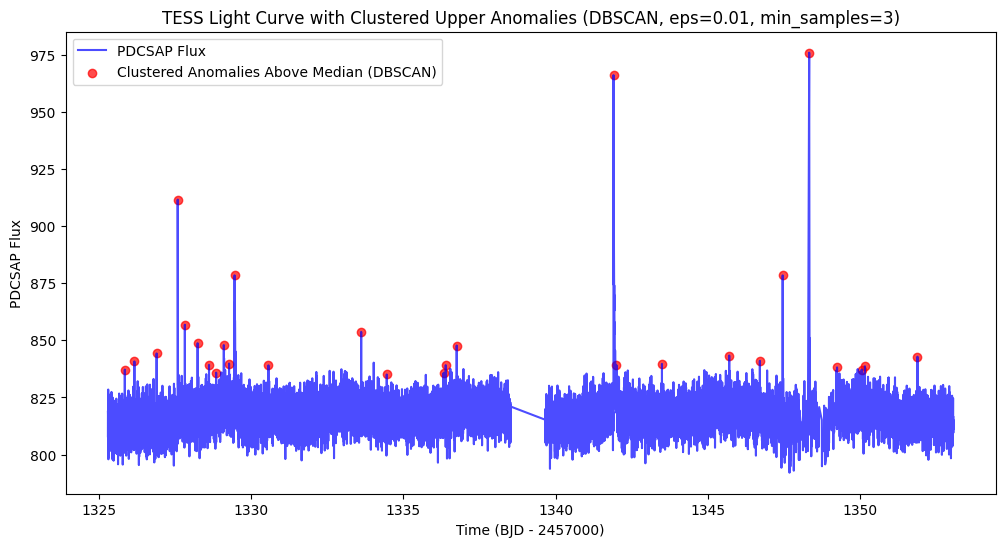

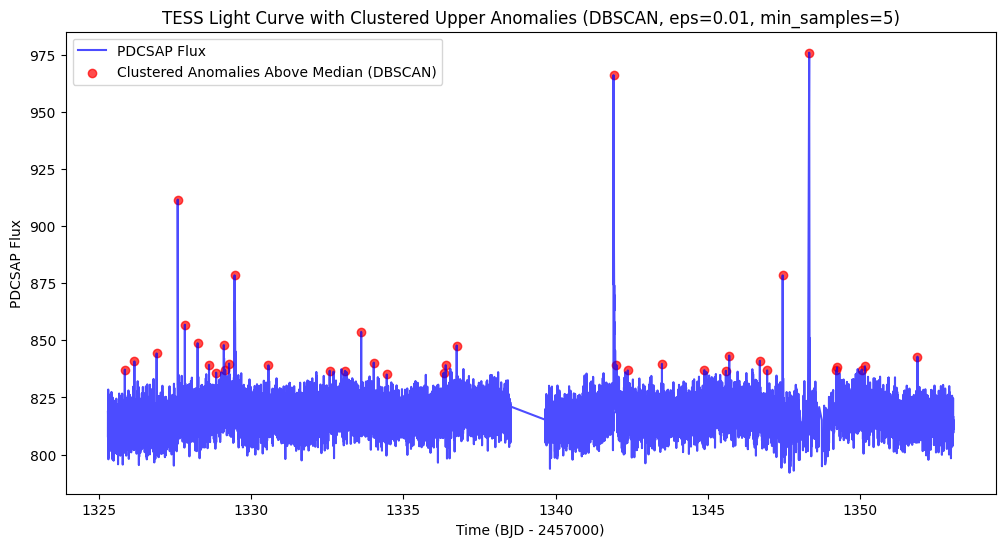

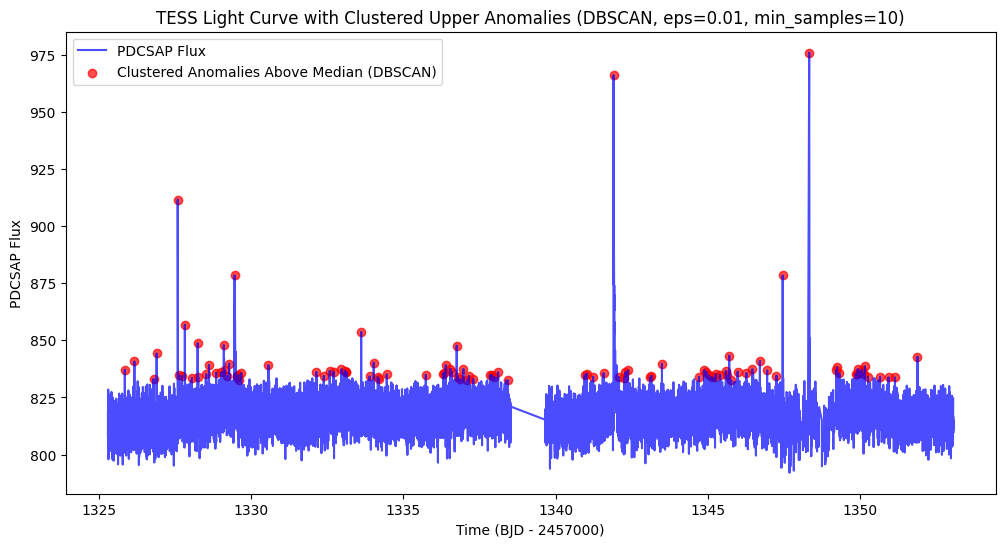

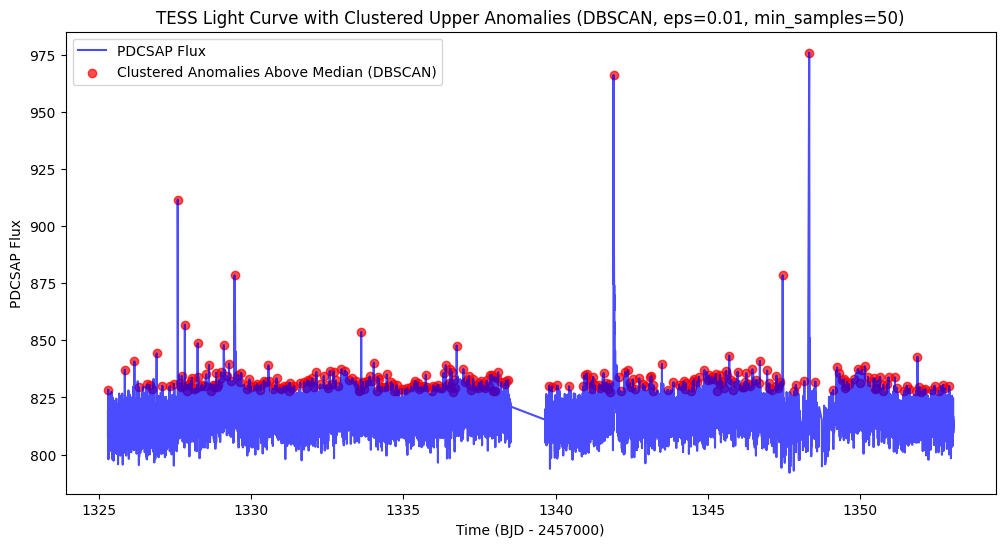

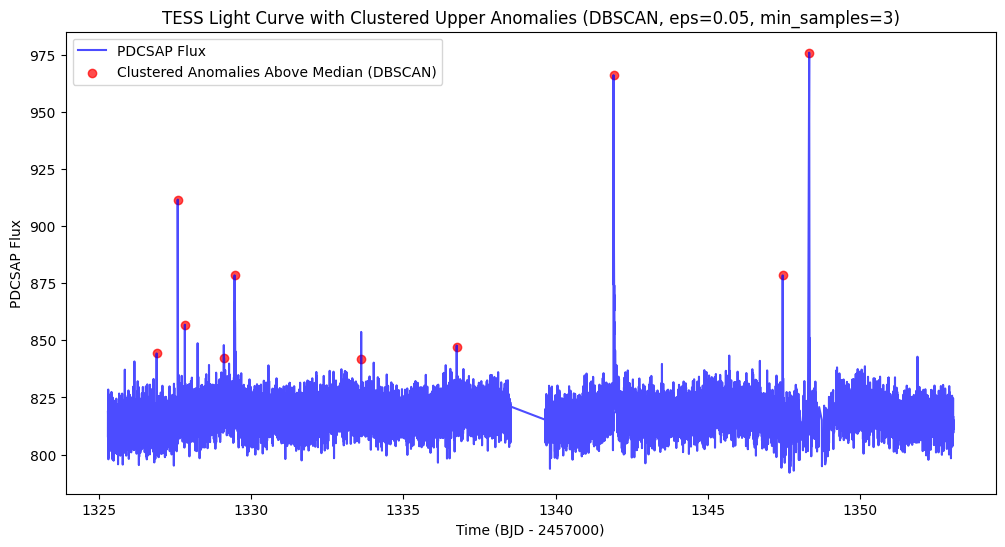

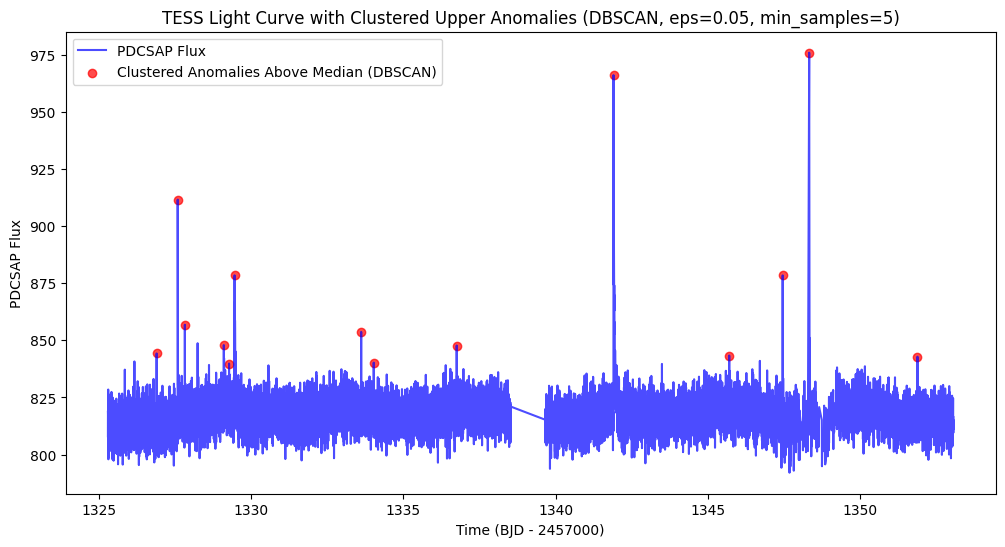

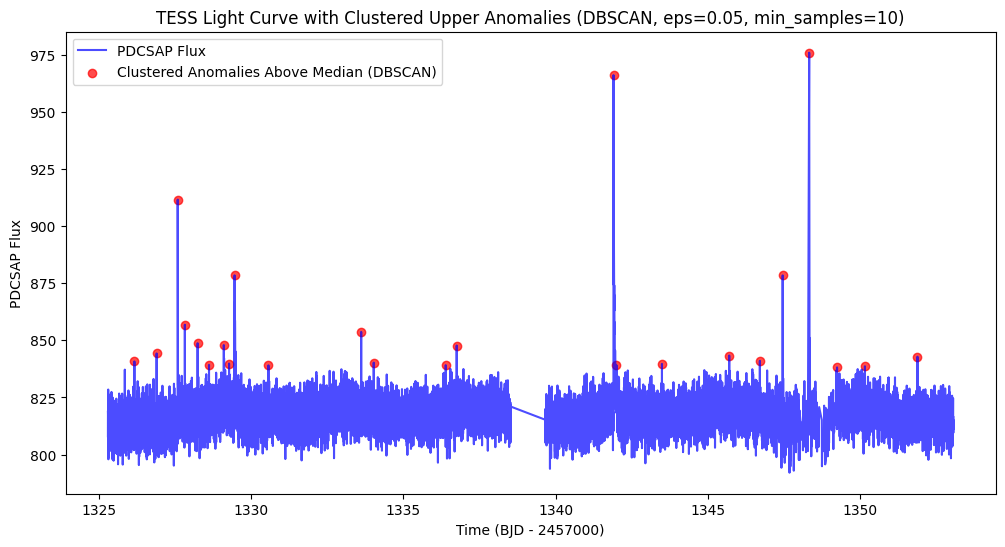

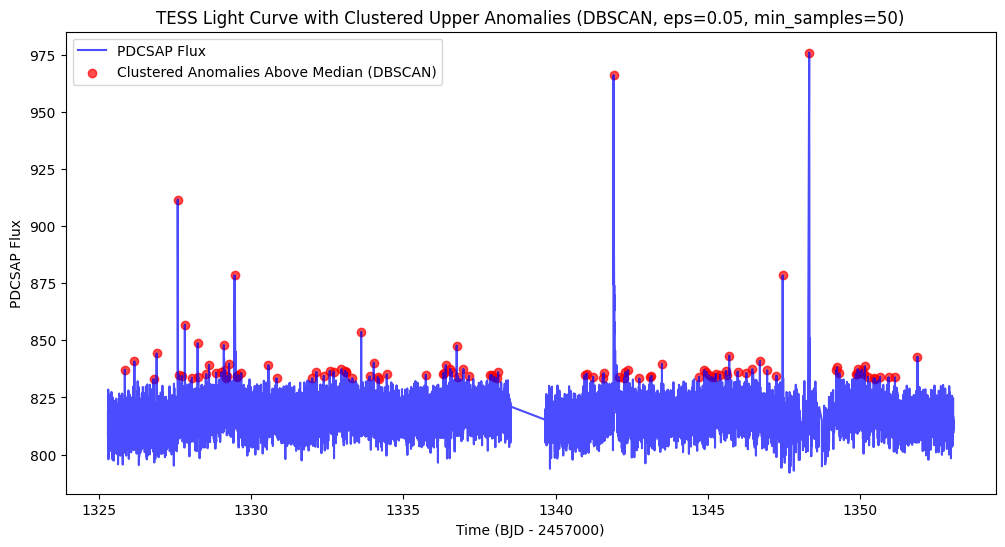

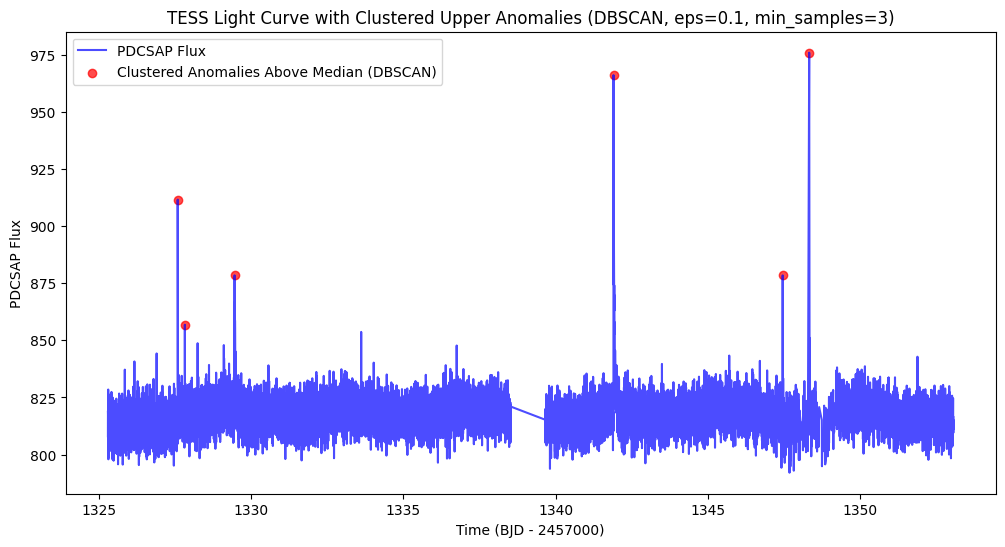

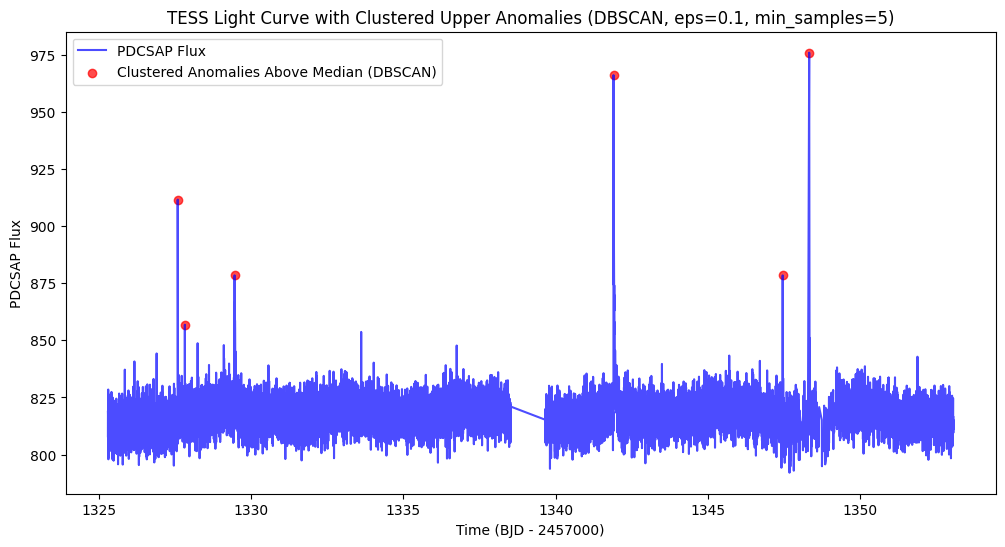

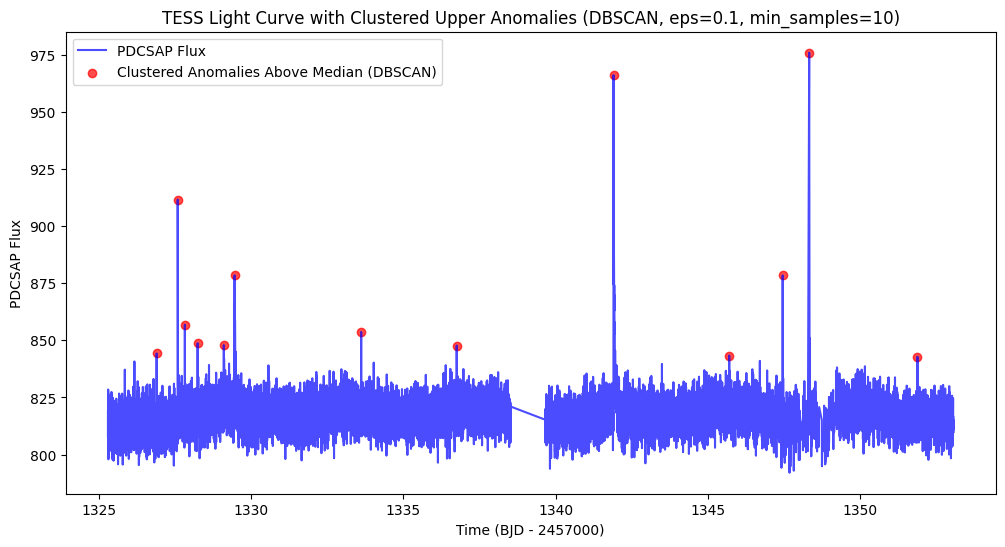

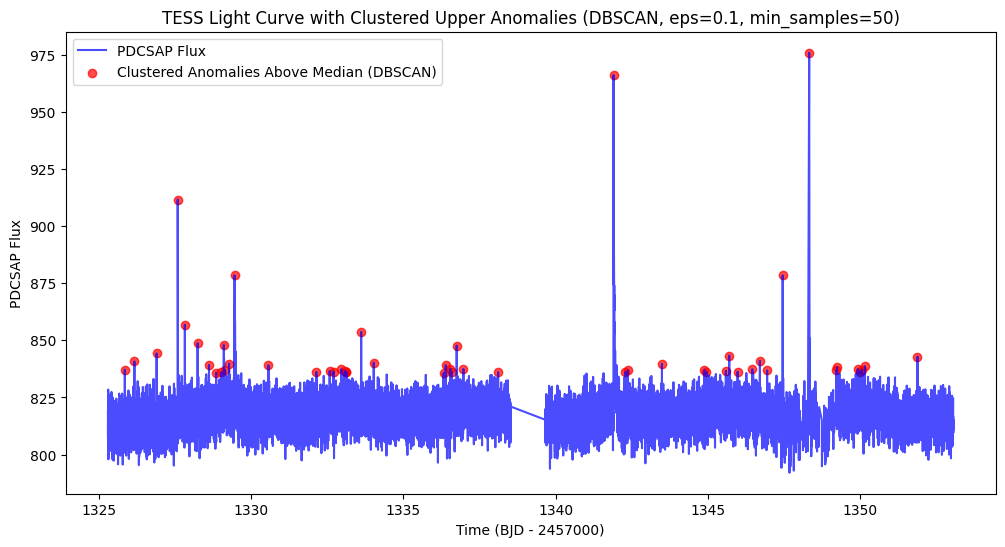

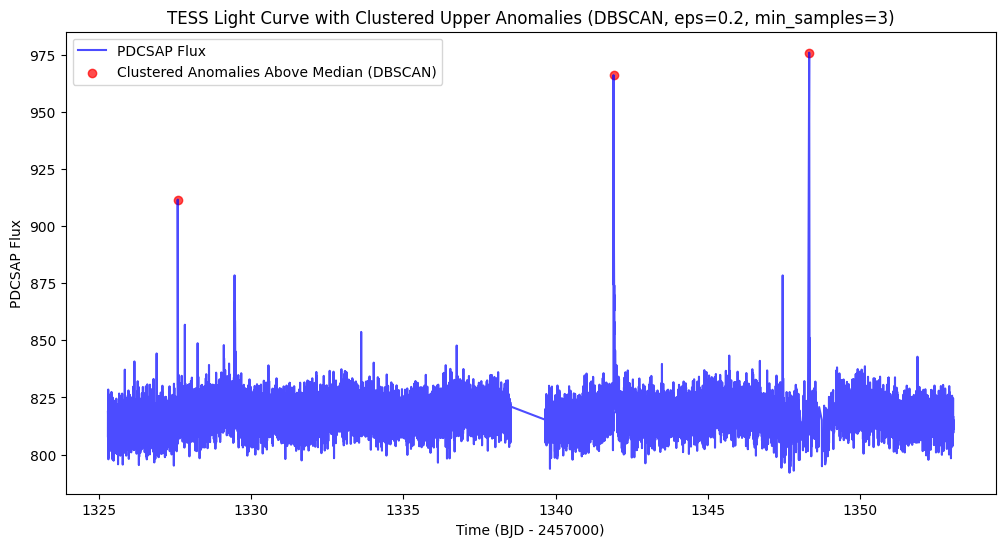

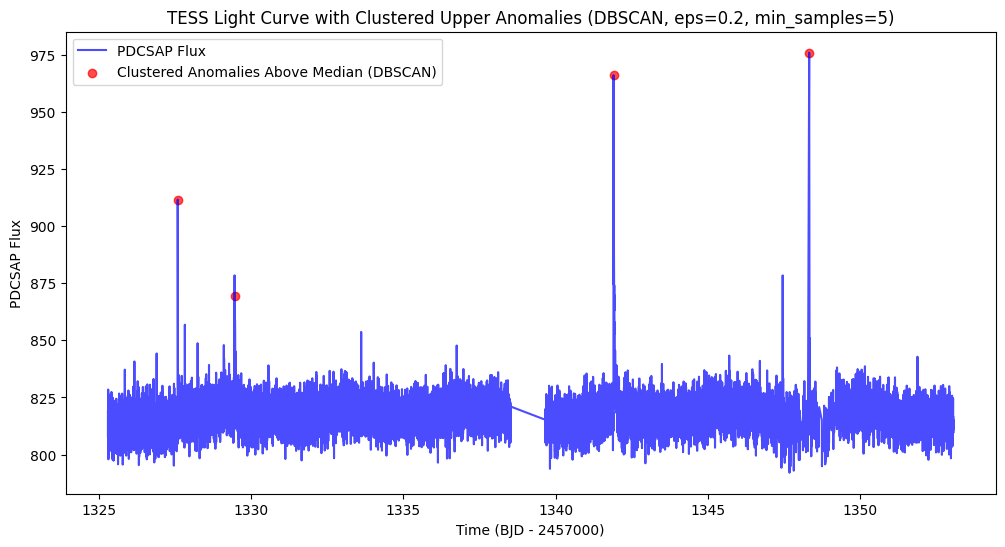

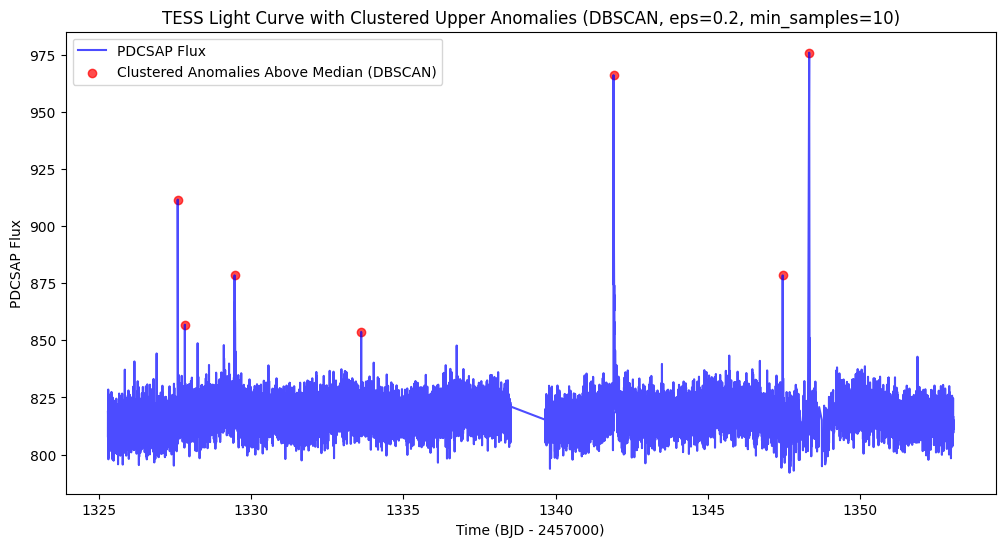

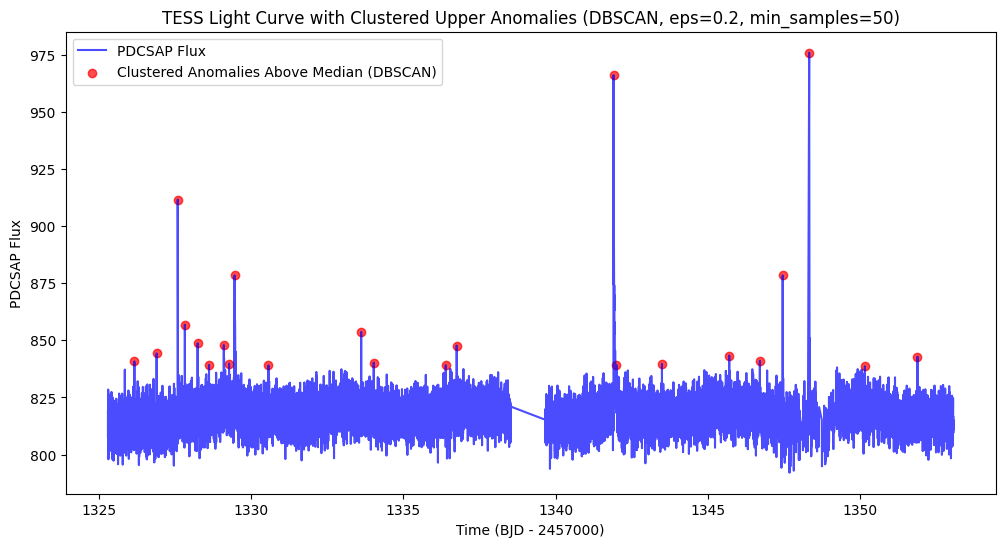

In [ ]:
## Grid search for hyperparameter tuning
# Define the parameter grid for DBSCAN
eps_values = [0.01, 0.05, 0.1, 0.2]
min_samples_values = [3, 5, 10, 50]

# Define time threshold for clustering consecutive anomalies
time_threshold = 0.02

# Get the median flux value to filter out low anomalies
median_flux = df['pdcsap_flux'].median()

# Iterate through each combination of eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Fit DBSCAN model
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(X_scaled)

        # Identify anomaly points (label -1)
        anomaly_indices = np.where(labels == -1)[0]
        anomaly_times = df.iloc[anomaly_indices]['time'].values

        # Cluster consecutive anomalies to avoid duplicate flare detections
        clustered_anomalies = []
        if len(anomaly_times) > 0:
            current_cluster = [anomaly_times[0]]

            for i in range(1, len(anomaly_times)):
                if anomaly_times[i] - anomaly_times[i - 1] <= time_threshold:
                    current_cluster.append(anomaly_times[i])
                else:
                    # Select the point with maximum flux in the cluster
                    cluster_flux = df.loc[df['time'].isin(current_cluster), 'pdcsap_flux']
                    max_flux_time = df.loc[cluster_flux.idxmax(), 'time']
                    # Filter out anomalies below the median
                    if df.loc[df['time'] == max_flux_time, 'pdcsap_flux'].values[0] > median_flux:
                        clustered_anomalies.append(max_flux_time)
                    current_cluster = [anomaly_times[i]]

            # Add the last cluster if not empty
            if current_cluster:
                cluster_flux = df.loc[df['time'].isin(current_cluster), 'pdcsap_flux']
                max_flux_time = df.loc[cluster_flux.idxmax(), 'time']
                if df.loc[df['time'] == max_flux_time, 'pdcsap_flux'].values[0] > median_flux:
                    clustered_anomalies.append(max_flux_time)

        # Create a dataframe for clustered anomalies
        clustered_anomalies_df = df[df['time'].isin(clustered_anomalies)]

        # Plot the time series with clustered anomalies (above median)
        plt.figure(figsize=(12, 6))
        plt.plot(df['time'], df['pdcsap_flux'], label='PDCSAP Flux', color='blue', alpha=0.7)
        plt.scatter(clustered_anomalies_df['time'], clustered_anomalies_df['pdcsap_flux'],
                    color='red', label='Clustered Anomalies Above Median (DBSCAN)', alpha=0.7)
        plt.xlabel('Time (BJD - 2457000)')
        plt.ylabel('PDCSAP Flux')
        plt.title(f'TESS Light Curve with Clustered Upper Anomalies (DBSCAN, eps={eps}, min_samples={min_samples})')
        plt.legend()
        plt.show()



In [ ]:
## Try Silhouette scores to find optimal eps and min_sample
# Store silhouette scores
silhouette_results = []

# Your loop starts here
for eps in eps_values:
    for min_samples in min_samples_values:
        # Fit DBSCAN model
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(X_scaled)

        # Count unique clusters (excluding noise)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Check if clustering is valid (at least 2 clusters and some non-noise points)
        if n_clusters >= 2 and np.any(labels != -1):
            non_noise_mask = labels != -1
            score = silhouette_score(X_scaled[non_noise_mask], labels[non_noise_mask])
            silhouette_results.append({
                'eps': eps,
                'min_samples': min_samples,
                'score': score,
                'n_clusters': n_clusters
            })
        else:
            silhouette_results.append({
                'eps': eps,
                'min_samples': min_samples,
                'score': -1,  # Invalid silhouette
                'n_clusters': n_clusters
            })

# Convert to DataFrame for easy sorting
silhouette_df = pd.DataFrame(silhouette_results)
best_result = silhouette_df.loc[silhouette_df['score'].idxmax()]

print("Best DBSCAN Parameters based on Silhouette Score:")
print(best_result)



📌 Best DBSCAN Parameters based on Silhouette Score:
eps            0.600000
min_samples    3.000000
score          0.908596
n_clusters     2.000000
Name: 35, dtype: float64


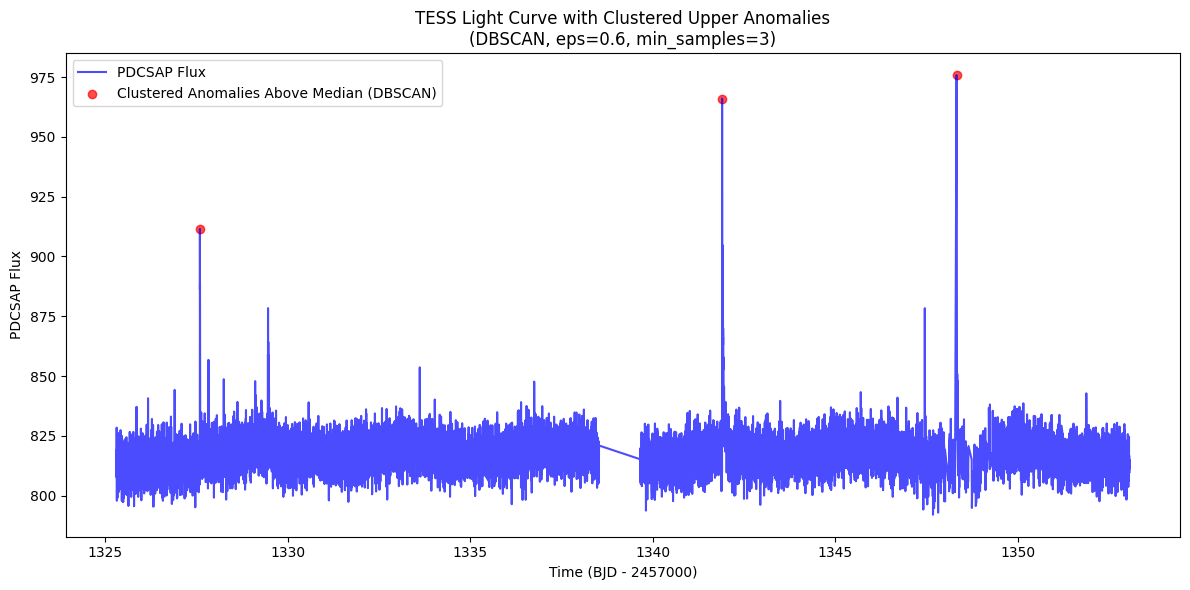

In [ ]:
## Visualize the result based on Silhouette scores
# DBSCAN parameters
eps = 0.6
min_samples = 3
time_threshold = 0.02
median_flux = df['pdcsap_flux'].median()

# Fit DBSCAN
model = DBSCAN(eps=eps, min_samples=min_samples)
labels = model.fit_predict(X_scaled)

# Identify anomaly indices (label = -1)
anomaly_indices = np.where(labels == -1)[0]
anomaly_times = df.iloc[anomaly_indices]['time'].values
anomaly_fluxes = df.iloc[anomaly_indices]['pdcsap_flux'].values

# --- Cluster nearby anomalies using NumPy vectorized logic ---
# Sort by time
sorted_idx = np.argsort(anomaly_times)
sorted_times = anomaly_times[sorted_idx]
sorted_fluxes = anomaly_fluxes[sorted_idx]

# Find split points where time difference > threshold
time_diffs = np.diff(sorted_times)
split_indices = np.where(time_diffs > time_threshold)[0] + 1

# Split into clusters
clusters = np.split(np.column_stack((sorted_times, sorted_fluxes)), split_indices)

# Select max-flux point from each cluster (if above median)
clustered_anomalies = [
    cluster[np.argmax(cluster[:, 1])][0]  # max flux time
    for cluster in clusters
    if cluster[np.argmax(cluster[:, 1])][1] > median_flux
]

# Create DataFrame for selected anomalies
clustered_anomalies_df = df[df['time'].isin(clustered_anomalies)]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['pdcsap_flux'], label='PDCSAP Flux', color='blue', alpha=0.7)
plt.scatter(clustered_anomalies_df['time'], clustered_anomalies_df['pdcsap_flux'],
            color='red', label='Clustered Anomalies Above Median (DBSCAN)', alpha=0.7)
plt.xlabel('Time (BJD - 2457000)')
plt.ylabel('PDCSAP Flux')
plt.title(f'TESS Light Curve with Clustered Upper Anomalies\n(DBSCAN, eps={eps}, min_samples={min_samples})')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
### Save models ###
dbscan = DBSCAN(eps=0.05, min_samples=10)

joblib.dump(dbscan, "dbscan.pkl")

files.download("dbscan.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>